In [1]:
import re
import missingno
import numpy as np
import pandas as pd

from typing import Union

SCREEN_SIZE_REGEXP = re.compile('\d+\.?\d*["|”]')
FLOAT_REGEXP = re.compile('\d+\.?\d*')   # not exactly "float"
INT_REGEXP = re.compile('\d+')
RAM_REGEXP = re.compile('[4|8|16|24|32|64]')
RESOLUTION_REGEXP = re.compile('\d+x\d+')
TRAIN_SIZE = 0.7

In [2]:
# !pip install missingno

# Основы машинного обучения
## Семинар 2. Регрессия

**Данные для регрессии**<br>
Источник: [kaggle](https://www.kaggle.com/datasets/keremabdullahoglu/laptop-price-dataset-april-2024) (описание и переменные там же).

#### Посмотрим на данные в целом

In [3]:
reg_df = pd.read_csv('laptop_prices.csv')
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3981 entries, 0 to 3980
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                3949 non-null   object 
 1   Product_Description  3980 non-null   object 
 2   Screen_Size          3785 non-null   object 
 3   RAM                  3730 non-null   object 
 4   Processor            3880 non-null   object 
 5   GPU                  3247 non-null   object 
 6   GPU_Type             3258 non-null   object 
 7   Resolution           3320 non-null   object 
 8   Condition            3981 non-null   object 
 9   Price                3980 non-null   float64
dtypes: float64(1), object(9)
memory usage: 311.1+ KB


**Почему object - это не очень хорошо**

In [4]:
array_int = np.array([1, 2, 3], dtype=int)
array_object = np.array([1, 2, 3], dtype='object')

In [5]:
array_object * 2

array([2, 4, 6], dtype=object)

In [6]:
array_object = np.array([1, 2, '3'], dtype='object')

In [7]:
array_int = pd.Series(np.arange(0, 10000))
array_object = array_int.astype('object')

In [8]:
%%timeit
_ = array_int * 5

17.7 μs ± 134 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
%%timeit
_ = array_object * 5

128 μs ± 1.11 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%%timeit
_ = array_int.values * 5

3.12 μs ± 46.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [11]:
%%timeit
_ = array_object.values * 5  # нивелируем плюсы numpy

116 μs ± 1.85 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Почему object - это не очень хорошо - конец**

In [12]:
reg_df.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,Lenovo,Lenovo ThinkPad L15 Gen 2 15.6” FHD Laptop Cor...,15.6,16,Intel Core i5-1135G7,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,344.99
1,Lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core...,14,16,Intel Core i5 7th Gen.,Intel HD Graphics 520,Integrated/On-Board Graphics,NaN,Very Good - Refurbished,189.99
2,Lenovo,"Lenovo ThinkPad E14 14"" Laptop Core i5 11th Ge...",14,16,Intel Core i5-1135G7,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080p,Good - Refurbished,289.99
3,Dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB ...",NaN,NaN,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99
4,ASUS,"🔥NEW Asus Vivobook 15.6"" TouchScreen Laptop In...",15.6,16,Intel Core i7-1255U,Intel Iris Xe Graphics,NaN,1920 x 1080,New,538.95


In [13]:
reg_df.isna().sum()

Brand                   32
Product_Description      1
Screen_Size            196
RAM                    251
Processor              101
GPU                    734
GPU_Type               723
Resolution             661
Condition                0
Price                    1
dtype: int64

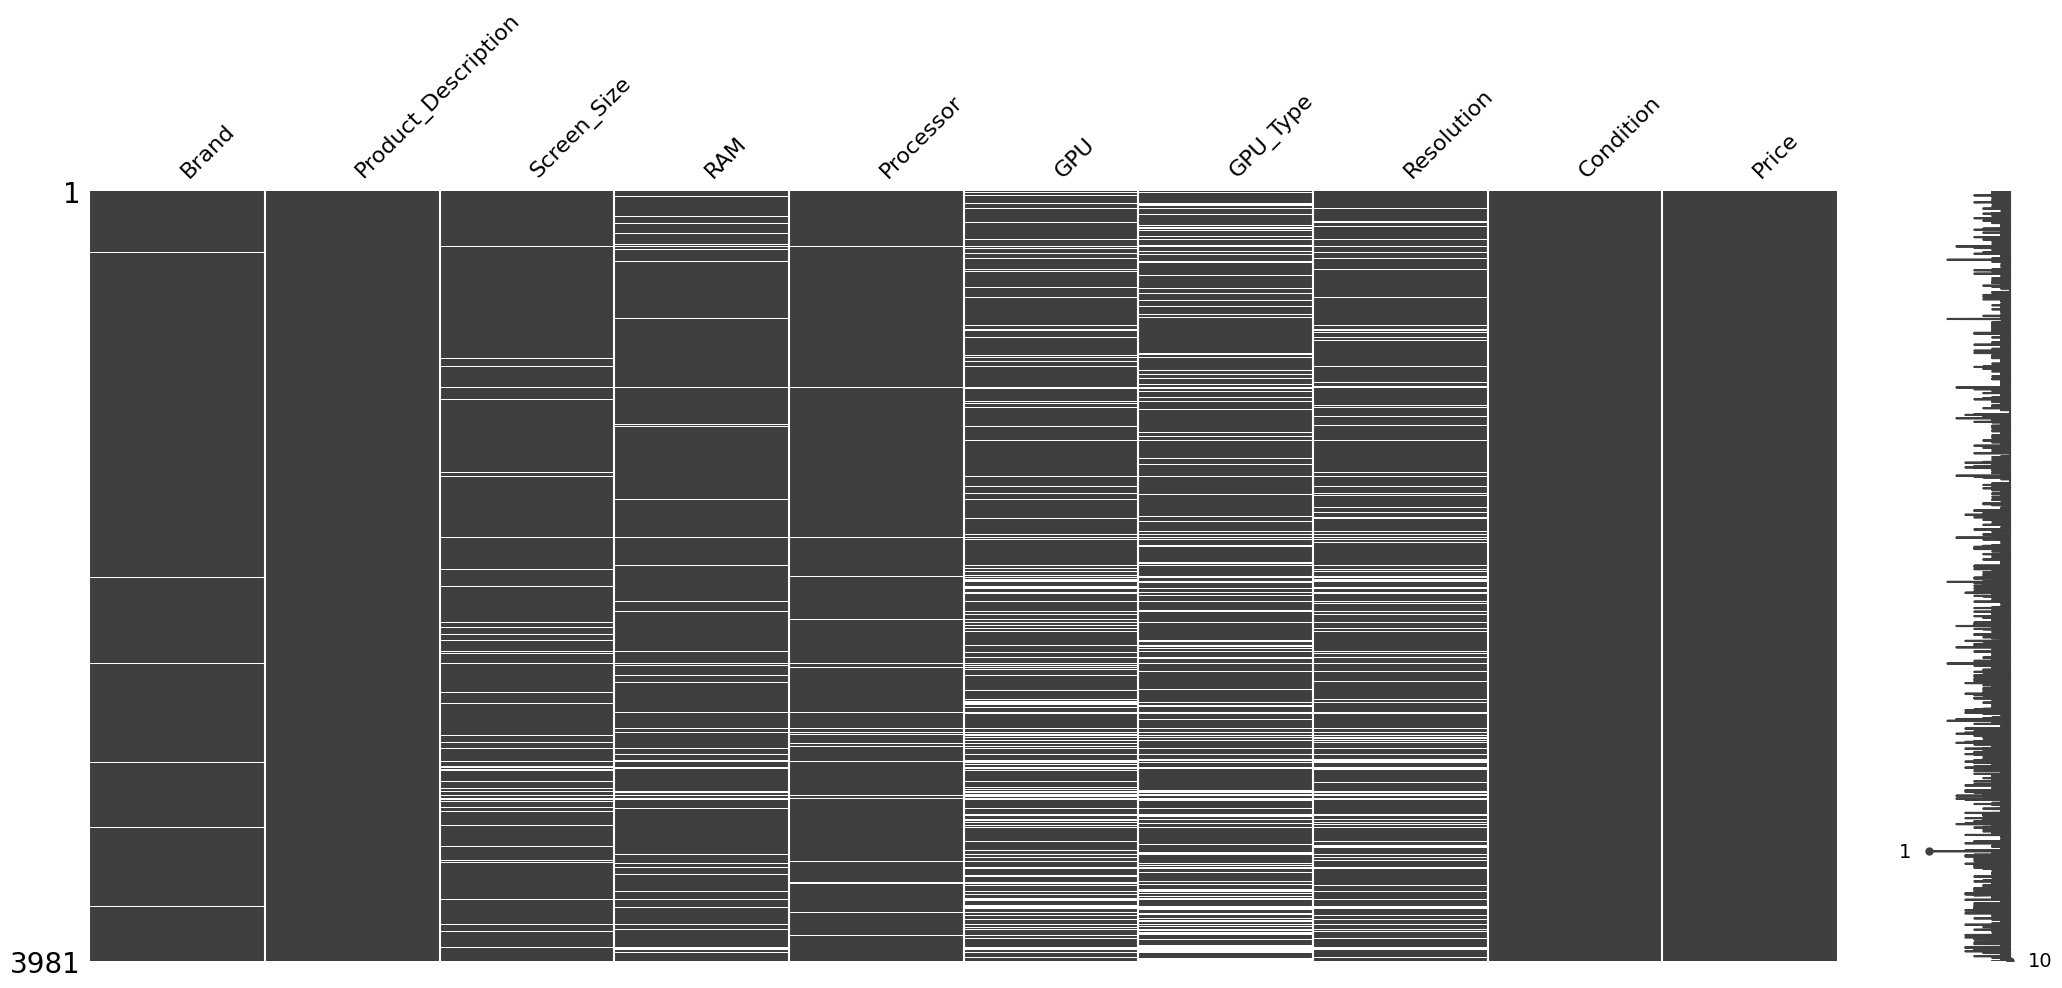

In [14]:
missingno.matrix(reg_df);

In [15]:
reg_df.duplicated().any()

False

#### Рассмотрим каждую переменную по отдельности
`Brand`

In [16]:
reg_df['Brand'].value_counts()

Brand
Dell                         1513
HP                            776
Lenovo                        773
Microsoft                     224
ASUS                          172
Acer                          131
Samsung                        72
MSI                            68
LG                             49
DELL                           49
LENOVO                         35
Gateway                        18
Apple                           8
MICROSOFT                       7
Asus                            7
Razer                           5
Panasonic                       5
Sony                            3
Intel                           2
Chuwi                           2
Dell Inc.                       2
Alienware                       2
Google                          2
GIGABYTE                        2
Ruggon                          1
Dell Commercial                 1
Lenovo Idea                     1
HP Commercial Remarketing       1
Dell Latitude                   1
Microsof

In [17]:
reg_df['Brand'].str.lower().value_counts()

Brand
dell                         1562
lenovo                        808
hp                            776
microsoft                     231
asus                          179
acer                          132
samsung                        73
msi                            68
lg                             49
gateway                        18
apple                           8
razer                           5
panasonic                       5
sony                            3
dell inc.                       2
intel                           2
alienware                       2
gigabyte                        2
chuwi                           2
google                          2
thinkpad                        1
avita                           1
aorus                           1
lenovo idea                     1
ruggon                          1
dell commercial                 1
hp commercial remarketing       1
dell latitude                   1
geo                             1
hewlett 

In [18]:
brands_mapper = {
    'dell inc.': 'dell',
    'lenovo idea': 'lenovo',
    'dell commercial': 'dell',
    'dell latitude': 'dell',
    'hp commercial remarketing': 'hp',
    'hewlett packard': 'hp',
    'lg electronics': 'lg',
    'dell gaming games game': 'dell',
    'microsoft surface': 'microsoft'
}

reg_df['Brand'] = reg_df['Brand'].str.lower().map(lambda br: brands_mapper.get(br, br))  # pd.Series.map / pd.Series.apply
# reg_df['Brand'] = reg_df['Brand'].str.lower().apply(lambda br: brands_mapper.get(br, br))
# pd.DataFrame.apply -> применяет map к всем pd.Series, которые в нем находятся

In [19]:
brand_counts = reg_df['Brand'].value_counts()
brand_counts

Brand
dell         1567
lenovo        809
hp            778
microsoft     232
asus          179
acer          132
samsung        73
msi            68
lg             50
gateway        18
apple           8
panasonic       5
razer           5
sony            3
intel           2
google          2
chuwi           2
alienware       2
gigabyte        2
eurocom         1
ruggon          1
avita           1
sager           1
getac           1
bytespeed       1
vaio            1
unbranded       1
thinkpad        1
huawei          1
geo             1
aorus           1
Name: count, dtype: int64

In [20]:
brands_to_mark_other = brand_counts.index[brand_counts.values < 20]
reg_df.loc[reg_df['Brand'].isin(brands_to_mark_other), 'Brand'] = 'other'

In [21]:
reg_df['Brand'].value_counts(dropna=False)

Brand
dell         1567
lenovo        809
hp            778
microsoft     232
asus          179
acer          132
samsung        73
msi            68
other          61
lg             50
NaN            32
Name: count, dtype: int64

In [22]:
# в колонке Brand остались пропущенные значения. Лучше всего было бы достать название бренда из описания

`Screen_Size`

In [23]:
reg_df.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,lenovo,Lenovo ThinkPad L15 Gen 2 15.6” FHD Laptop Cor...,15.6,16,Intel Core i5-1135G7,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,344.99
1,lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core...,14,16,Intel Core i5 7th Gen.,Intel HD Graphics 520,Integrated/On-Board Graphics,NaN,Very Good - Refurbished,189.99
2,lenovo,"Lenovo ThinkPad E14 14"" Laptop Core i5 11th Ge...",14,16,Intel Core i5-1135G7,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080p,Good - Refurbished,289.99
3,dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB ...",NaN,NaN,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99
4,asus,"🔥NEW Asus Vivobook 15.6"" TouchScreen Laptop In...",15.6,16,Intel Core i7-1255U,Intel Iris Xe Graphics,NaN,1920 x 1080,New,538.95


In [24]:
reg_df['Screen_Size'].isna().sum()

196

In [25]:
reg_df['Screen_Size'].nunique(dropna=False)

64

In [26]:
reg_df['Screen_Size'].unique().size

64

In [27]:
len(reg_df['Screen_Size'].unique())

64

In [28]:
reg_df['Screen_Size'].astype(float)  # 14.6"

ValueError: could not convert string to float: '14"'

In [29]:
def process_screen_size(value: Union[float|str]) -> float:  # typing кое-где считается хорошим тоном
    if type(value) == float:
        return value

    regexp_result = FLOAT_REGEXP.search(value)

    if regexp_result is None:
        return None
    else:
        return float(regexp_result.group())

def extract_screen_size(description: str) -> str:
    if pd.isna(description):
        return None
    
    regexp_result = SCREEN_SIZE_REGEXP.search(description)

    if regexp_result is None:
        return None
        
    return regexp_result.group()[:-1]


reg_df['Screen_Size'] = reg_df['Screen_Size'].apply(lambda val: process_screen_size(val))
screen_size = pd.Series([extract_screen_size(description) for description in reg_df['Product_Description'].tolist()]).astype(float)

reg_df.loc[reg_df['Screen_Size'].isna(), 'Screen_Size'] = screen_size[reg_df['Screen_Size'].isna()]

In [30]:
reg_df['Screen_Size'].isna().sum()

80

In [31]:
reg_df['Screen_Size'].describe()

count    3901.000000
mean       14.600500
std         1.282368
min         0.000000
25%        14.000000
50%        14.000000
75%        15.600000
max        39.600000
Name: Screen_Size, dtype: float64

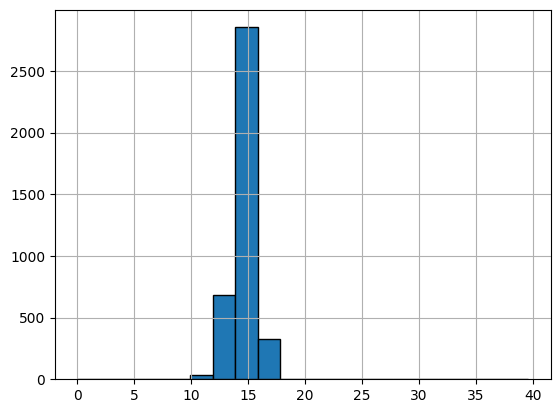

In [32]:
reg_df['Screen_Size'].hist(bins=20, edgecolor='black');

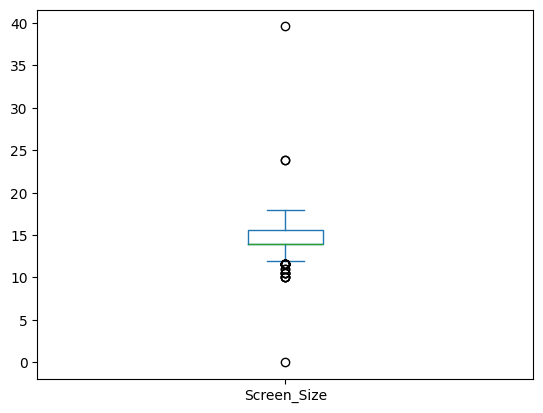

In [33]:
reg_df['Screen_Size'].plot.box();

In [34]:
Q1 = reg_df['Screen_Size'].quantile(0.25)
Q3 = reg_df['Screen_Size'].quantile(0.75)
IQR = Q3 - Q1

right_limit = Q3 + 1.5 * IQR
left_limit = 5
# left_limit = Q1 - 1.5 * IQR

screen_size_filter = (reg_df['Screen_Size'].values >= left_limit) & (reg_df['Screen_Size'].values <= right_limit)

![](https://i2.wp.com/miro.medium.com/1*Xb0RiyFI-8LQ4gysW1YP1w.png)
`RAM`

In [35]:
reg_df.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,lenovo,Lenovo ThinkPad L15 Gen 2 15.6” FHD Laptop Cor...,15.6,16,Intel Core i5-1135G7,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,344.99
1,lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core...,14.0,16,Intel Core i5 7th Gen.,Intel HD Graphics 520,Integrated/On-Board Graphics,NaN,Very Good - Refurbished,189.99
2,lenovo,"Lenovo ThinkPad E14 14"" Laptop Core i5 11th Ge...",14.0,16,Intel Core i5-1135G7,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080p,Good - Refurbished,289.99
3,dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB ...",15.6,NaN,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99
4,asus,"🔥NEW Asus Vivobook 15.6"" TouchScreen Laptop In...",15.6,16,Intel Core i7-1255U,Intel Iris Xe Graphics,NaN,1920 x 1080,New,538.95


In [36]:
reg_df['RAM'].value_counts(dropna=False)

RAM
16       1614
8        1464
32        333
NaN       251
4         186
64         51
12         12
8GB        11
16GB        8
up          6
16gb        6
40          4
128         4
4GB         4
24          4
8gb         4
Up          4
8GB,        3
32gb        2
512         2
32GB        1
4GB,        1
64gb        1
2050        1
upto        1
20          1
256         1
16GB,       1
Name: count, dtype: int64

In [37]:
def process_ram(value: Union[int|float|str]) -> str:
    if pd.isna(value):
        return pd.NA
    
    regexp_result = INT_REGEXP.search(value)

    if regexp_result is None:
        return pd.NA

    ram_int = int(regexp_result.group())

    if ram_int > 128:
        return pd.NA

    return str(ram_int)

reg_df['RAM'] = reg_df['RAM'].map(lambda val: process_ram(val))

In [38]:
ram_counts = reg_df['RAM'].value_counts()
ram_counts

RAM
16     1629
8      1482
32      336
4       191
64       52
12       12
24        4
40        4
128       4
20        1
Name: count, dtype: int64

In [39]:
ram_filter = reg_df['RAM'].isin(ram_counts.index[ram_counts.values >= 20]) & reg_df['RAM'].notna()
# можно попробовать достать, но сейчас не будем: важен принцип

`Processor`

In [40]:
reg_df.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,lenovo,Lenovo ThinkPad L15 Gen 2 15.6” FHD Laptop Cor...,15.6,16,Intel Core i5-1135G7,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,344.99
1,lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core...,14.0,16,Intel Core i5 7th Gen.,Intel HD Graphics 520,Integrated/On-Board Graphics,NaN,Very Good - Refurbished,189.99
2,lenovo,"Lenovo ThinkPad E14 14"" Laptop Core i5 11th Ge...",14.0,16,Intel Core i5-1135G7,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080p,Good - Refurbished,289.99
3,dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB ...",15.6,<NA>,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99
4,asus,"🔥NEW Asus Vivobook 15.6"" TouchScreen Laptop In...",15.6,16,Intel Core i7-1255U,Intel Iris Xe Graphics,NaN,1920 x 1080,New,538.95


In [41]:
reg_df.sample(5)

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
3335,dell,Dell Ultrabook E7450 Core i7-5600u 2.6GHz 16GB...,14.0,16,Intel Core i7 5th Gen.,Intel HD Graphics 5500,Integrated/On-Board Graphics,1920x1080,Good - Refurbished,280.00
3297,lenovo,"Lenovo X13 2nd Gen 14"" FHD+ I5-1145G7 512GB SS...",14.0,16,Intel Core i5 11th Gen.,Intel(R) Iris(R) Xe Graphics,Integrated/On-Board Graphics,1920 x 1200,Very Good - Refurbished,457.99
2505,hp,"HP Pavilion x360 14m-dy0023dx 14"" Touchscreen ...",14.0,8,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,439.00
336,asus,"New Asus Vivobook F15 15.6"" FHD Touch i7-1255U...",15.6,16,Intel Core i7 12th Gen.,Intel Iris Xe Graphic,Integrated/On-Board Graphics,1920 x 1080,New,581.99
3764,microsoft,"Microsoft 8VC-00001 Surface Go 3 10.5"" Intel i...",10.5,8,Intel Core i3 10th Gen.,Intel UHD Graphics 615,Integrated/On-Board Graphics,1920 x 1280,Open box,659.98


In [42]:
reg_df['Processor'].str.contains('Intel').sum()

3425

In [43]:
reg_df['Processor'].str.contains('AMD').sum()

122

In [44]:
reg_df['Processor'].size

3981

In [45]:
reg_df.loc[~(reg_df['Processor'].str.contains('Intel') | reg_df['Processor'].str.contains('AMD')), :]

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
7,acer,"Acer Spin 14"" Touchscreen Laptop Intel Core i3...",14.0,8,i3-1215U,NaN,NaN,1920 x 1080,New,309.00
15,lenovo,"Lenovo ThinkPad L13 13.3"" Laptop Intel Core 10...",13.3,<NA>,NaN,Intel UHD Graphics,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,202.45
19,lenovo,"Lenovo Flex 5i 14"" Touch Laptop i5-1235U 8GB R...",14.0,8,i5-1235U,Intel Integrated Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1200,New,419.00
43,dell,Dell Latitude 5490 Laptop (Choose Specs + Cond...,14.0,16,i5-8350U,Intel HD Graphics 620,Integrated/On-Board Graphics,1366 x 768,Open box,149.99
159,msi,"MSI Summit E13FlipEvo A13MT-243US - 13.4"" Touc...",13.4,16,i7,Intel Iris Xe Graphics,NaN,1920 x 1200,New,834.95
...,...,...,...,...,...,...,...,...,...,...
3975,dell,Dell Latitude 9420 Business 14 Ultrabook 2in1 ...,14.0,16,i5-1145G7,Integrated Graphics,NaN,1920 x 1200,Excellent - Refurbished,792.76
3976,dell,Dell Latitude Rugged 5424 Business 14 Laptop C...,14.0,16,i7-8650U,AMD RADEON RX 540,NaN,1920 x 1080,Excellent - Refurbished,527.21
3977,dell,Dell Precision 3560 Workstation 15 15.6 Laptop...,15.6,32,i7-1165G7,Integrated Graphics,NaN,1920 x 1080,Excellent - Refurbished,610.86
3978,dell,Dell XPS 9320 PLUS 13 13.4 Laptop Core i7 4k u...,13.4,16,i7-1260P,Integrated Graphics,NaN,3456 x 2160,Excellent - Refurbished,628.30


In [46]:
caselist = [
    (reg_df['Processor'].fillna('Unknown').str.lower().str.contains('intel'), 'Intel'),
    (reg_df['Processor'].fillna('Unknown').str.lower().str.contains('amd'), 'AMD'),
]

reg_df['Processor'].case_when(caselist=caselist)

0           Intel
1           Intel
2           Intel
3           Intel
4           Intel
          ...    
3976     i7-8650U
3977    i7-1165G7
3978     i7-1260P
3979        Intel
3980          NaN
Name: Processor, Length: 3981, dtype: object

In [47]:
intel_mask = reg_df['Processor'].str.lower().str.contains('intel').fillna(False)
amd_mask = reg_df['Processor'].str.lower().str.contains('amd').fillna(False)
unknown_mask = ~(intel_mask | amd_mask)

reg_df.loc[intel_mask, 'Processor'] = 'Intel'
reg_df.loc[amd_mask, 'Processor'] = 'AMD'
reg_df.loc[unknown_mask, 'Processor'] = 'Unknown'

/var/folders/h6/lv17v1r10lz21g745pd6774h0tgc4z/T/ipykernel_18505/4079246552.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  intel_mask = reg_df['Processor'].str.lower().str.contains('intel').fillna(False)
/var/folders/h6/lv17v1r10lz21g745pd6774h0tgc4z/T/ipykernel_18505/4079246552.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  amd_mask = reg_df['Processor'].str.lower().str.contains('amd').fillna(False)


In [48]:
reg_df['Processor'].value_counts()

Processor
Intel      3433
Unknown     426
AMD         122
Name: count, dtype: int64

`GPU`

In [49]:
reg_df.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,lenovo,Lenovo ThinkPad L15 Gen 2 15.6” FHD Laptop Cor...,15.6,16,Intel,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,344.99
1,lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core...,14.0,16,Intel,Intel HD Graphics 520,Integrated/On-Board Graphics,NaN,Very Good - Refurbished,189.99
2,lenovo,"Lenovo ThinkPad E14 14"" Laptop Core i5 11th Ge...",14.0,16,Intel,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080p,Good - Refurbished,289.99
3,dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB ...",15.6,<NA>,Intel,Intel UHD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99
4,asus,"🔥NEW Asus Vivobook 15.6"" TouchScreen Laptop In...",15.6,16,Intel,Intel Iris Xe Graphics,NaN,1920 x 1080,New,538.95


In [50]:
reg_df.sample(5)

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
3891,dell,Windows 7 pro 64b i7 16GB RAM Dell 1000GB SSD ...,14.0,<NA>,Intel,NaN,Integrated/On-Board Graphics,NaN,New,999.00
218,hp,"HP ZBook Fury 15 G7 FHD 15.6"" WS i7-10850H 2.7...",15.6,16,Intel,AMD Radeon Pro W5500M,Dedicated Graphics,1920 x 1080,Open box,599.00
1445,lenovo,"Lenovo V14 IIL 14"" Intel Core i3 10th 8GB RAM ...",14.0,8,Intel,Intel UHD Graphics,Integrated/On-Board Graphics,1920 x 1080,Open box,300.00
1459,dell,"15.6"" TOUCH Dell laptop Precision 5530 i7 8850...",15.6,32,Intel,Nvdia p2000,Integrated/On-Board Graphics,FHD,Excellent - Refurbished,549.99
3825,dell,"Dell Inspiron 15 3593 Laptop 15.6"" Intel i3-10...",15.6,8,Intel,Intel UHD Graphics,Integrated/On-Board Graphics,1920 x 1080,New,599.99


In [51]:
gpu_intel_mask = reg_df['GPU'].str.lower().str.contains('intel').fillna(False)
gpu_amd_mask = reg_df['GPU'].str.lower().str.contains('amd').fillna(False)
gpu_nvidia_mask = reg_df['GPU'].str.lower().str.contains('nvidia').fillna(False)
gpu_unknown_mask = ~(gpu_intel_mask | gpu_amd_mask | gpu_nvidia_mask)

reg_df.loc[gpu_intel_mask, 'GPU'] = 'Intel'
reg_df.loc[gpu_amd_mask, 'GPU'] = 'AMD'
reg_df.loc[gpu_nvidia_mask, 'GPU'] = 'Nvidia'
reg_df.loc[gpu_unknown_mask, 'GPU'] = 'Unknown'

/var/folders/h6/lv17v1r10lz21g745pd6774h0tgc4z/T/ipykernel_18505/522825850.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gpu_intel_mask = reg_df['GPU'].str.lower().str.contains('intel').fillna(False)
/var/folders/h6/lv17v1r10lz21g745pd6774h0tgc4z/T/ipykernel_18505/522825850.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gpu_amd_mask = reg_df['GPU'].str.lower().str.contains('amd').fillna(False)
/var/folders/h6/lv17v1r10lz21g745pd6774h0tgc4z/T/ipykernel_18505/522825850.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

In [52]:
reg_df['GPU'].value_counts()

GPU
Intel      2446
Unknown     912
Nvidia      468
AMD         155
Name: count, dtype: int64

`GPU_Type`

In [53]:
reg_df['GPU_Type'].value_counts()

GPU_Type
Integrated/On-Board Graphics                          2678
Dedicated Graphics                                     534
Intel Iris Xe                                           17
Intel UHD Graphics                                       5
Intel Iris Xe Graphics                                   4
Integrated                                               3
Integrated Graphics                                      3
Iris Xe Graphics                                         2
Not available                                            2
Intergrated Intel UHD Graphics                           1
Intel Arc A370M                                          1
AMD Radeon(TM) 530 Graphics with 4G GDDR5 graphics       1
NVIDIA Quadro M1200                                      1
NVIDIA GeForce RTX 4080                                  1
Intel® Iris Xe Graphics                                  1
Intel® UHD Graphics                                      1
Intel HD Graphics 520                          

In [54]:
# не следует использовать, будет слишком сильно пересекаться с GPU

`Resolution`

In [55]:
reg_df['Resolution'].value_counts()

Resolution
1920 x 1080                                   2002
1920 x 1200                                    326
1366 x 768                                     296
2560 x 1600                                     88
1920x1080                                       69
                                              ... 
2240x1400                                        1
FHD                                              1
Touchscreen                                      1
5K                                               1
15.6" UltraSharp FHD IPS Touch (1920x1080)       1
Name: count, Length: 76, dtype: int64

In [56]:
def process_resolutuon(value: Union[int|float|str]) -> str:
    if pd.isna(value):
        return np.nan
    
    regexp_result = RESOLUTION_REGEXP.search(value)

    if regexp_result is None:
        return np.nan

    x, y = regexp_result.group().split('x')

    return float(x) * float(y)

reg_df['Resolution'] = [process_resolutuon(string) for string in reg_df['Resolution'].str.replace(' ', '').tolist()]

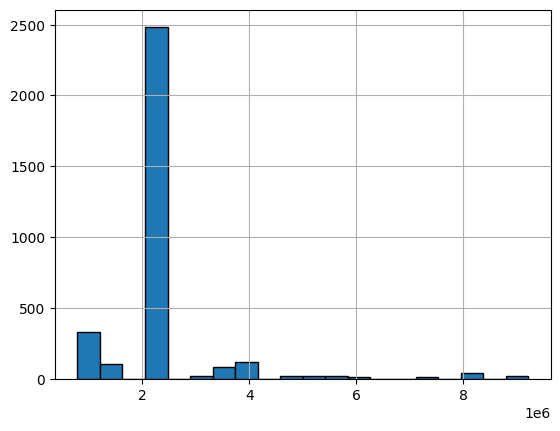

In [57]:
reg_df['Resolution'].hist(bins=20, edgecolor='black');

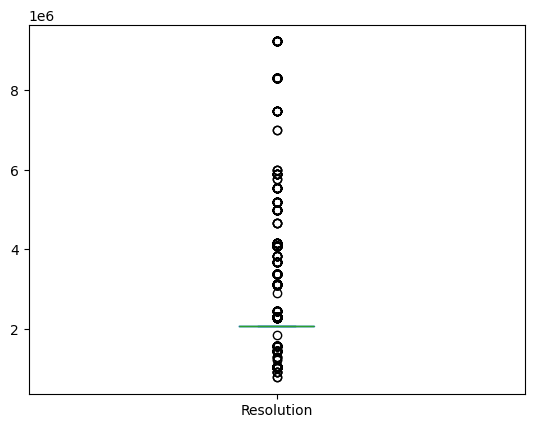

In [58]:
reg_df['Resolution'].plot.box();

In [59]:
reg_df['Resolution_log'] = np.log(reg_df['Resolution'].values)

In [60]:
# то, во сколько надо возвести 2, чтобы получить 8
# log(8, основание=2) = 3

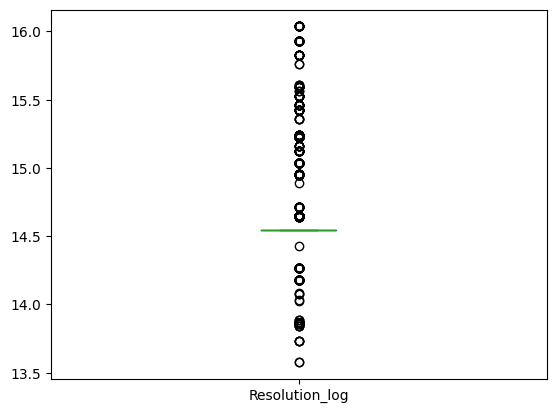

In [61]:
reg_df['Resolution_log'].plot.box();

In [62]:
# 4, 16, 64, ...

# log(x, основание=4)
# 1,  2,  3

In [63]:
resolution_filter = reg_df['Resolution_log'].notna()

`Condition`

In [64]:
reg_df.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price,Resolution_log
0,lenovo,Lenovo ThinkPad L15 Gen 2 15.6” FHD Laptop Cor...,15.6,16,Intel,Intel,Integrated/On-Board Graphics,2073600.0,Very Good - Refurbished,344.99,14.544797
1,lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core...,14.0,16,Intel,Intel,Integrated/On-Board Graphics,NaN,Very Good - Refurbished,189.99,NaN
2,lenovo,"Lenovo ThinkPad E14 14"" Laptop Core i5 11th Ge...",14.0,16,Intel,Intel,Integrated/On-Board Graphics,2073600.0,Good - Refurbished,289.99,14.544797
3,dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB ...",15.6,<NA>,Intel,Intel,Integrated/On-Board Graphics,2073600.0,Very Good - Refurbished,349.99,14.544797
4,asus,"🔥NEW Asus Vivobook 15.6"" TouchScreen Laptop In...",15.6,16,Intel,Intel,NaN,2073600.0,New,538.95,14.544797


In [65]:
reg_df['Condition'].value_counts()

Condition
New                        1156
Open box                   1046
Excellent - Refurbished     623
Very Good - Refurbished     600
Good - Refurbished          554
Used                          1
--                            1
Name: count, dtype: int64

In [66]:
condition_filter = ~reg_df['Condition'].isin(['Used', '--'])

Самое главное - таргет!

`Price`

In [67]:
reg_df['Price'].describe().round(2)

count    3980.00
mean      521.74
std       241.28
min         0.00
25%       324.56
50%       498.85
75%       700.00
max       999.99
Name: Price, dtype: float64

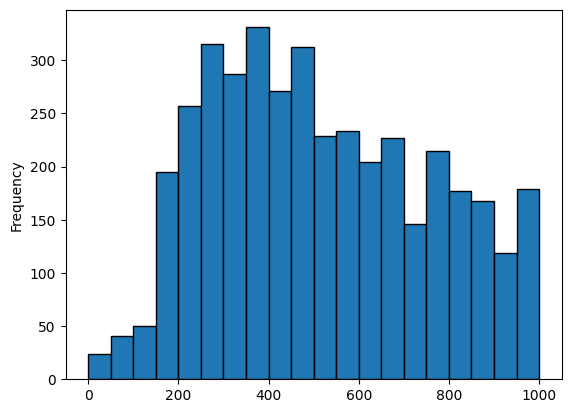

In [68]:
reg_df['Price'].plot.hist(edgecolor='black', bins=20);

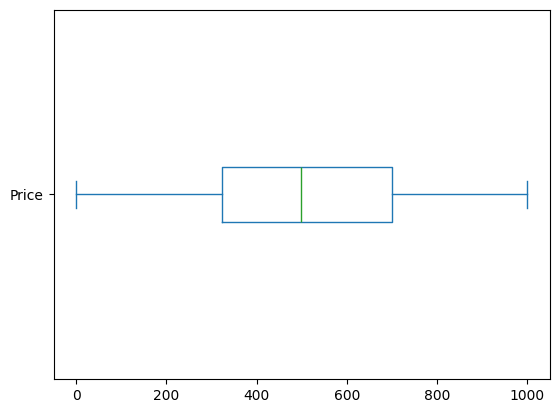

In [69]:
reg_df['Price'].plot.box(vert=False);

### Подготовим данные к моделированию
![](https://www.statology.org/wp-content/uploads/2021/02/dummy6.png)

In [70]:
reg_df.columns

Index(['Brand', 'Product_Description', 'Screen_Size', 'RAM', 'Processor',
       'GPU', 'GPU_Type', 'Resolution', 'Condition', 'Price',
       'Resolution_log'],
      dtype='object')

In [71]:
variables = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'Resolution_log', 'Condition', 'Price']

dummy_variables = ['Brand', 'RAM', 'Processor', 'GPU', 'Condition']
target = 'Price'

model_data = reg_df.loc[
    screen_size_filter
    & ram_filter
    & resolution_filter
    & condition_filter,
    variables
].reset_index(drop=True)

model_data = pd.get_dummies(
    model_data,
    columns=dummy_variables,
    dtype='int',
    drop_first=True
)

In [72]:
reg_df[['Processor']]

,Processor
0,Intel
1,Intel
2,Intel
3,Intel
4,Intel
...,...
3976,Unknown
3977,Unknown
3978,Unknown
3979,Intel


In [73]:
# Processor_AMD	Processor_Intel	Processor_Unknown
# 1	                  0	                  0

In [74]:
# Processor_AMD	Processor_Intel	Processor_Unknown
# 1	                  0	                0

In [75]:
pd.get_dummies(reg_df[['Processor']], dtype='int', drop_first=True)

,Processor_Intel,Processor_Unknown
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
3976,0,1
3977,0,1
3978,0,1
3979,1,0


In [76]:
model_data.head()

,Screen_Size,Resolution_log,Price,Brand_asus,Brand_dell,Brand_hp,Brand_lenovo,Brand_lg,Brand_microsoft,Brand_msi,...,RAM_8,Processor_Intel,Processor_Unknown,GPU_Intel,GPU_Nvidia,GPU_Unknown,Condition_Good - Refurbished,Condition_New,Condition_Open box,Condition_Very Good - Refurbished
0,15.6,14.544797,344.99,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,14.0,14.544797,289.99,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0
2,15.6,14.544797,538.95,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,15.6,14.544797,369.95,0,0,1,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0
4,14.0,14.544797,309.00,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0


Разделим на train & test

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X = model_data.drop(columns=[target])
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)  # random_state=42

### Линейная регрессия как статистический метод
<img src="https://github.com/hse-python-mirec/dap_mirec_2022/blob/main/seminar9/images/08_estimating_coefficients.png?raw=true">

Что изображено на схеме?
- Черные точки - это **наблюдаемые значения** x и y.
- Синяя линия - это наша **линия полученная при минимизации квадратов ошибок**.
- Красные линии - это **остатки**, которые представляют собой расстояния между наблюдаемыми значениями и линией наименьших квадратов.

Как коэффициенты модели соотносятся с линией наименьших квадратов?
- $ \beta_0 $ - это **точка пересечения** (значение $ y $, когда $ x $ = 0)
- $ \beta_1 $ - это **наклон** (изменение $ y $, деленное на изменение $ x $)

Вот графическое изображение этих вычислений:

<img src="https://github.com/hse-python-mirec/dap_mirec_2022/blob/main/seminar9/images/08_slope_intercept.png?raw=true">

Давайте попробуем использовать библиотеку **Statsmodels** для оценки коэффициентов модели на наших данных:

In [79]:
# y = k * x + b

In [79]:
import statsmodels.formula.api as smf

# создаём модель по заданной формуле и обучаем ее на data при помощи метода .fit()

# y = k * x + b
# Price = k * Screen_Size + b
# Price ~ Screen_Size  -  специальный формат записи, вдохновлен формулами из языка R

lm = smf.ols(formula='Price ~ Screen_Size', data=model_data).fit()  # y ~ x   ->   k * Screen_Size + b = Price

# выведем полученные коэффициенты модели
lm.params

# Intercept -> b
# Screen_Size -> k

Intercept      68.545546
Screen_Size    31.215257
dtype: float64

In [81]:
# Price = 31.2 * Screen_Size + 68.5

# Screen_Size = 20 -> Price = 31.2 * 20 + 68.5 = 692.5$

In [82]:
# Screen_Size = 0 -> Price = 31.2 * 0 + 68.5 = 68.5$
# Intercept (68.5) - то, чему равна переменная Price при условии, что все независимые переменные (Screen_Size) равны 0

In [80]:
# Screen_Size (31.2) - то, как меняется переменная Price при увеличении переменной Screen_Size на 1
# если мы увеличиваем диагональ на 1 дюйм, цена вырастет на 31.2$

31.2 * 5

156.0

Как такое получается? Давайте немного разберемся.

**Аналитическое решение линейной регрессии**

Пусть у нас есть обучающий набор данных с $n$ наблюдениями и $d$ признаками. Каждое наблюдение $i$ имеет $d$ признаков $x_{i1}, x_{i2}, ..., x_{id}$ и соответствующий целевой признак $y_i$. Задача линейной регрессии состоит в том, чтобы найти линейную функцию, которая наилучшим образом соответствует данным. Мы можем записать модель линейной регрессии следующим образом:

$$
\hat{y} = f(x) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_d x_d = \sum_{j=0}^{d-1} w_j x_j
$$

Как понять, что такое "соответствует"? Пойдем от обратного и поймем, что такое "не соответствует". Для этого определим т. н. функцию ошибки:

$$
MSE=\frac{1}{n} \sum_{i=0}^{n} (\sum_{j=0}^{d-1} w_j x_j - y)^2
$$

*формулу выше следует читать так: сначала мы для i-го наблюдения считаем по формуле предсказание, вычитаем из него истинное значение, затем складываем эту ошибку по всем предсказаниям и делим на n, усредняя*

**Вопрос.** MSE расшифровывается как mean squared error. Где в этой формуле mean, где squared и где error?

Эту ошибку нам хотелось бы минимизировать, в идеале подойдет 0. В реальности до нуля добраться не получится, но можно попробовать найти такие веса $w_j$, чтобы функция имела минимальное значение. Для этого нам нужно найти производную функции и приравнять ее к 0:

$$
2 \cdot \frac{1}{n} \cdot (\sum_{j=0}^{d-1} w_j x_j - y) \cdot \sum_{j=0}^{d-1} x_j = \frac{2}{n} \cdot (\sum_{j=0}^{d-1} w_j x_j - y) \cdot \sum_{j=0}^{d-1} x_j
$$

Вектор градиента функционала ошибки в матричном виде:

$$
\nabla Q(w) = \frac{2}{n} X^T (X \cdot w - y)
$$

Приравниваем к 0:

$\frac{2}{n} X^T (X \cdot w - y) = 0$

Убираем дробь, умножив обе части на $\frac{n}{2}$:

$X^T (X \cdot w - y) = 0$

Раскрываем скобки и перенеся $X^T y$:

$X^T X \cdot w = X^T y$

Решаем относительно w:

$w = (X^T X)^{-1} X^T y$

**Задание.** А теперь давайте напишем это на Python:

In [84]:
model_data.head()

,Screen_Size,Resolution_log,Price,Brand_asus,Brand_dell,Brand_hp,Brand_lenovo,Brand_lg,Brand_microsoft,Brand_msi,...,RAM_8,Processor_Intel,Processor_Unknown,GPU_Intel,GPU_Nvidia,GPU_Unknown,Condition_Good - Refurbished,Condition_New,Condition_Open box,Condition_Very Good - Refurbished
0,15.6,14.544797,344.99,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,14.0,14.544797,289.99,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0
2,15.6,14.544797,538.95,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,15.6,14.544797,369.95,0,0,1,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0
4,14.0,14.544797,309.00,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0


In [81]:
X = model_data[['Screen_Size', 'Resolution_log']].values

X = np.hstack((np.ones((X.shape[0], 1)), X))  # np.ones((X.shape[0], 1)) - массив из единиц, имеющий форму (N, 1), где N - количество строк в матрице X
# это фича при константе

y = model_data['Price'].values

weights = np.linalg.inv(X.T @ X) @ X.T @ y  # считаем по формуле

In [82]:
lm = smf.ols(formula='Price ~ Screen_Size + Resolution_log', data=model_data).fit()
lm.params.values

array([-2267.99592375,    32.20572878,   159.31189502])

In [115]:
weights

array([-2267.99592374,    32.20572878,   159.31189502])

#### Градиентный спуск

$\nabla Q(w) = \frac{2}{n} X^T (X \cdot w - y) $

Тут мы вместо того, что приравнивать производную к нулю, и потом иметь дело с дорогостоящими матричными операциями (обращением матрицы), остановимся собственно на производной (градиенте). Если производная - это направление наискорейшего роста функции, а нам нужна минимизация функции, направимся "по производной", но "в другую сторону":

In [119]:
# обратите внимание, градиент при текущих весах (полученных аналитически) минимален - потому что мы специально его минимизировали

2 / X.shape[0] * X.T @ (X @ weights - y)

# здесь массив из трех значений, каждое из значений - производная по i-му весу. Совокупность производных - градиент

array([-2.32895315e-10, -3.53896154e-09, -3.50415202e-09])

In [168]:
def compute_grad(X: np.ndarray, w: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    X: data
    w: weights
    y: target
    """
    grad = 2 / X.shape[0] * X.T @ (X @ w - y)
    
    return grad

def optimize(
    X: np.ndarray,
    y: np.ndarray,
    alpha=0.001,
    niter=1000
):
    w = np.random.normal(5, 10, X.shape[1])
    history = [w]
    
    for i in range(niter):
        grad = compute_grad(X, w, y)

        w -= alpha * grad

        # compute loss
        predict = X @ w
        loss = ((predict - y) ** 2).sum()

        history.append([w, loss])

    return w, history

In [169]:
weigths_gd, history = optimize(X, y)

In [170]:
weights

array([-2267.99592374,    32.20572878,   159.31189502])

In [171]:
weigths_gd

array([-0.47406153, 16.47076865, 19.60564628])

In [ ]:
# как мы видим, решение проблемы "в лоб" не проходит, в т. ч. из-за того, что данные не были должным образом подготовлены. Об этом поговорим далее

### Линейная регрессия как метод машинного обучения

In [90]:
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score

metrics = set()

def regression_report(actual_test, predicted_test, actual_train, predicted_train):
    rmse = round(root_mean_squared_error(actual_test, predicted_test), 3)  # mean_squared_error(..., squared=False)
    mae = round(mean_absolute_error(actual_test, predicted_test), 3)
    mape = round(mean_absolute_percentage_error(actual_test, predicted_test), 3)
    
    r2_train = round(r2_score(actual_train, predicted_train), 3)
    r2_test = round(r2_score(actual_test, predicted_test), 3)

    print('--------- Model metrics ---------')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    print(f'R2 train: {r2_train}')
    print(f'R2 test: {r2_test}')

    return rmse, mae, mape, r2_train, r2_test

#### Baseline

In [91]:
predict_baseline_train = np.array([y_train.mean()] * y_train.size)
predict_baseline_test = np.array([y_train.mean()] * y_test.size)

metrics.add(
    ('baseline',) + regression_report(y_test, predict_baseline_test, y_train, predict_baseline_train)
)

--------- Model metrics ---------
RMSE: 240.999
MAE: 204.931
MAPE: 7517308405029514.0
R2 train: 0.0
R2 test: -0.0


#### Разные виды моделей

In [92]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

In [93]:
lr = LinearRegression()
lr.fit(X_train, y_train)

predict_lr_train = lr.predict(X_train)
predict_lr_test = lr.predict(X_test)

metrics.add(('lr',) + regression_report(y_test, predict_lr_test, y_train, predict_lr_train))

--------- Model metrics ---------
RMSE: 199.93
MAE: 157.72
MAPE: 9448749303765080.0
R2 train: 0.303
R2 test: 0.312


In [94]:
lasso = Lasso(alpha=0.3)
lasso.fit(X_train, y_train)

predict_lasso_train = lasso.predict(X_train)
predict_lasso_test = lasso.predict(X_test)

metrics.add(('lasso',) + regression_report(y_test, predict_lasso_test, y_train, predict_lasso_train))

--------- Model metrics ---------
RMSE: 200.313
MAE: 158.212
MAPE: 9492346070083524.0
R2 train: 0.301
R2 test: 0.309


In [95]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

predict_ridge_train = ridge.predict(X_train)
predict_ridge_test = ridge.predict(X_test)

metrics.add(('ridge',) + regression_report(y_test, predict_ridge_test, y_train, predict_ridge_train))

--------- Model metrics ---------
RMSE: 199.927
MAE: 157.724
MAPE: 9448493395662328.0
R2 train: 0.303
R2 test: 0.312


In [96]:
elastic = ElasticNet(alpha=0.1)
elastic.fit(X_train, y_train)

predict_elastic_train = elastic.predict(X_train)
predict_elastic_test = ridge.predict(X_test)

metrics.add(('elastic',) + regression_report(y_test, predict_elastic_test, y_train, predict_elastic_train))

--------- Model metrics ---------
RMSE: 199.927
MAE: 157.724
MAPE: 9448493395662328.0
R2 train: 0.268
R2 test: 0.312


In [97]:
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

predict_sgd_train = sgd.predict(X_train)
predict_sgd_test = sgd.predict(X_test)

metrics.add(('sgd',) + regression_report(y_test, predict_sgd_test, y_train, predict_sgd_train))

--------- Model metrics ---------
RMSE: 211.869
MAE: 172.295
MAPE: 1.0391838048783998e+16
R2 train: 0.203
R2 test: 0.227


In [98]:
metrics_df = pd.DataFrame(metrics, columns=['model', 'rmse', 'mae', 'mape', 'r2_train', 'r2_test'])
metrics_df

,model,rmse,mae,mape,r2_train,r2_test
0,baseline,240.999,204.931,7.517308e+15,0.000,-0.000
1,lr,199.930,157.720,9.448749e+15,0.303,0.312
2,ridge,199.927,157.724,9.448493e+15,0.303,0.312
3,lasso,200.313,158.212,9.492346e+15,0.301,0.309
4,elastic,199.927,157.724,9.448493e+15,0.268,0.312
5,sgd,211.869,172.295,1.039184e+16,0.203,0.227
